# AlpesHearth

## Caso de estudio AlpesHearth. 

El jupyter notebook aqui presente se basa en el caso de estudio AlpesHearth, el cual tiene como objetivos:
- Aplicar técnicas de regresión para construir un modelo predictivo que permita estimar el riesgo cardiovascular de una persona siguiendo el ciclo de machine learning.
- Determinar los principales factores de riesgo cardiovascular con base en los datos.
- Aplicar y comprender un modelo de regresión lineal.
- Reconocer posibles sesgos del modelo de aprendizaje de máquina.
- Comunicar de forma clara y sintética los resultados obtenidos.

Se utilizaron las siguientes librerias de Python para el procesamiento y analisis de datos: 
- Pandas
- Scikit-Learn
- Matplotlib, Seaborn

#### Importar las librerias

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [2]:
from importlib.metadata import version
print(f"Versión de Pandas: {version('pandas')}")
print(f"Versión de Numpy: {version('numpy')}")
print(f"Versión de Matplotlib: {version('matplotlib')}")
print(f"Versión de Seaborn: {version('seaborn')}")

Versión de Pandas: 2.3.3
Versión de Numpy: 2.2.6
Versión de Matplotlib: 3.10.8
Versión de Seaborn: 0.13.2


### Exploración de los datos

In [3]:
datos_model = pd.read_csv('./Datos/Datos Lab 1.csv')

In [4]:
data = datos_model.copy()

In [5]:
data.head()

,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
0,isDx5313,"November 08, 2023",M,44.0,114.300,1.720,38.600,100.000,112/83,228.0,...,High,N,172.000,0.581,112.0,83.0,Hypertension Stage 1,121.0,19.880,HIGH
1,LHCK2961,20/03/2024,F,57.0,92.923,1.842,33.116,106.315,101/91,158.0,...,High,Y,184.172,0.577,101.0,91.0,Hypertension Stage 2,57.0,16.833,INTERMEDIARY
2,WjVn1699,2021-05-27,F,NaN,73.400,1.650,27.000,78.100,90/74,135.0,...,High,N,165.000,0.473,90.0,74.0,Normal,45.0,12.600,LOW
3,dCDO1109,"April 18, 2022",F,35.0,113.300,1.780,35.800,79.600,92/89,158.0,...,Moderate,Y,178.000,0.447,92.0,89.0,Hypertension Stage 1,94.0,14.920,HIGH
4,pnpE1080,01/11/2024,F,48.0,102.200,1.750,33.400,106.700,121/68,207.0,...,Low,Y,175.000,0.610,121.0,68.0,Elevated,128.0,18.870,HIGH


Aqui podemos ver como hay columnas de datos repetidos y/o muy parecidos. Por ejemplo, Height (m) y Height (cm), Waist-to-Height Ratio Height y Abdominal Circumference, BMI Weight y Height etc.

A la hora de realizar el analisis estadistico, sera necesario ver cuales de estas variables son redundantes y no nos aportan al modelo. Asimismo, hay que revisar para casos tales como las dos estaturas, si coinciden. De no coincidir, habra que realizar un promedio o utilizar alguna otra tecnica.

In [6]:
display(data.sample(5))

,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
300,zhzN4535,05-18-2021,M,35.0,71.800,1.610,27.700,107.400,129/77,179.0,...,High,N,161.000,0.667,NaN,77.0,Elevated,72.0,15.570,LOW
784,sGfv1658,2021-04-17,F,NaN,100.900,1.780,31.800,109.400,113/99,176.0,...,Low,Y,178.000,0.615,113.0,99.0,Hypertension Stage 2,111.0,15.530,HIGH
939,wIEl0490,25/03/2025,F,70.0,85.240,1.797,23.601,82.224,125/72,224.0,...,High,Y,179.736,0.457,125.0,72.0,Elevated,127.0,15.450,LOW
954,FyWl3017,05 Oct 21,F,50.0,95.670,1.631,37.858,70.184,116/72,166.0,...,High,N,163.102,0.430,116.0,72.0,Normal,92.0,16.692,LOW
1324,KdCM6392,2021-01-03,F,72.0,92.602,1.936,31.961,108.304,91/105,298.0,...,Moderate,N,193.591,0.559,91.0,105.0,Hypertension Stage 2,199.0,16.902,INTERMEDIARY


In [7]:
data.shape

(1639, 24)

Esto nos dice que el conjunto de datos esta compuesto por 1.639 registros (filas) y 24 variables (columnas). 

In [8]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1639 entries, 0 to 1638
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Patient ID                    1639 non-null   object 
 1   Date of Service               1639 non-null   object 
 2   Sex                           1639 non-null   object 
 3   Age                           1571 non-null   float64
 4   Weight (kg)                   1566 non-null   float64
 5   Height (m)                    1578 non-null   float64
 6   BMI                           1586 non-null   float64
 7   Abdominal Circumference (cm)  1578 non-null   float64
 8   Blood Pressure (mmHg)         1639 non-null   object 
 9   Total Cholesterol (mg/dL)     1571 non-null   float64
 10  HDL (mg/dL)                   1557 non-null   float64
 11  Fasting Blood Sugar (mg/dL)   1585 non-null   float64
 12  Smoking Status                1639 non-null   object 
 13  Dia

Arriba podemos ver el detalle de cada columna, como el nombre, el número de valores no nulos (en este caso al tener 1.639, indica que no se tienen valores faltantes) y el tipo de los datos de cada columna, al igual que el número de columnas con cada tipo.

Es interesante ver que las columnas que no son numéricas (int o float) son `Patient ID`, `Date of Service`, `Sex`, `Blood Pressure (mmHg)`, `Smoking Status`, `Diabetes Status`, `Physical Activity Level`, `Family History of CVD`, y `Blood Pressure Category`, las cuales están en formato object, esto es algo importante y que debemos tener en cuenta. 

Como sabemos que `Blood Pressure Category` = `Systolic BP` / `Diastolic BP`, habra que reemplazar los NULLs por los respectivos valores de `Blood Pressure Category`. Mas adelante se revisara si estos valores son redundantes y si sera necesario remover alguna de estas columnas.

Un insumo imprescindible para entender un conjunto de datos es el diccionario, ya que este nos permite conocer el significado de cada variable y sus rangos válidos.  

Al mismo tiempo, al revisar los valores non-null de cada una de las columnas, podemos ver que hay muchos datos NULL dentro de la base de datos. Por lo que se debera realizar algo al respecto.

In [9]:
cols_con_null = []

for col in data.columns:
    if data[col].count() != len(data):
        cols_con_null.append(col)

cols_con_null

['Age',
 'Weight (kg)',
 'Height (m)',
 'BMI',
 'Abdominal Circumference (cm)',
 'Total Cholesterol (mg/dL)',
 'HDL (mg/dL)',
 'Fasting Blood Sugar (mg/dL)',
 'Height (cm)',
 'Waist-to-Height Ratio',
 'Systolic BP',
 'Diastolic BP',
 'Estimated LDL (mg/dL)',
 'CVD Risk Score']

In [10]:
diccionario = pd.read_excel('./Datos/DiccPacientes.xlsx')
pd.set_option('display.max_colwidth', None)
diccionario

,Nombre Columna,Tipo de dato,Comentarios
0,Patient ID,String,Identificador del paciente
1,Date of Service,Date,Fecha de la atención
2,Sex,String,"Sexo (Femenino, Masculino)"
3,Age,Integer,Edad
4,Weight (kg),Float,Peso
5,Height (m),Float,Altura
6,BMI,Float,Índice de masa corporal
7,Abdominal Circumference (cm),Float,Circunferencia abdominal
8,Blood Pressure (mmHg),String,"Presión sanguínea, de la forma ""<Presión arterial sistólica>/<Presión arterial diastólica>"""
9,Total Cholesterol (mg/dL),Float,Colesterol total


Con el fin de enriquecer el modelo, se revisaran las siguientes variables mas adelante:

Derivadas de datos existentes
- Grupo etario
- Categoria de BMI
- Categoria de glucosa
- Ratio colesterol
- Pulse Pressure
- Mean Arterial Pressure

Fuentes externas
- Mes
- Dias de la semana
- Estacion del anio

Scores clinicos establecidos
- Framingham Risk Score
- ASCVD Risk Score

Interacciones
- Fumador + Diabetes
- BMI * Actividad Fisica
- Edad * Presion Arterial

In [11]:
data.describe()

,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Estimated LDL (mg/dL),CVD Risk Score
count,1571.000000,1566.000000,1578.000000,1586.000000,1578.000000,1571.000000,1557.000000,1585.000000,1571.000000,1563.000000,1578.000000,1554.000000,1582.000000,1610.000000
mean,46.803186,85.666006,1.757439,28.424744,91.538861,199.043673,56.183558,117.836860,175.770082,0.522440,125.632637,82.887536,113.235896,18.227281
std,13.039479,21.712504,0.118012,7.309275,13.427985,59.388670,16.721702,32.379634,11.695880,0.085692,22.577463,15.503625,61.435291,10.767666
min,6.134000,13.261000,1.371000,4.317000,49.542000,-1.256000,0.008000,15.306000,136.498000,0.250000,49.914000,31.720000,-92.055000,-20.057000
25%,37.000000,67.100000,1.666500,22.600000,79.700000,150.000000,42.000000,92.000000,167.000000,0.453000,108.000000,71.000000,62.000000,15.150000
50%,46.000000,86.314000,1.760000,28.000000,91.200000,199.000000,56.000000,115.000000,176.000000,0.519000,125.000000,82.000000,112.000000,16.967000
75%,55.000000,104.801500,1.850000,33.963000,102.267250,250.000000,70.000000,139.000000,185.000000,0.582000,141.000000,93.000000,159.000000,18.900000
max,89.420000,158.523000,2.146000,53.028000,136.336000,385.679000,110.315000,219.667000,214.394000,0.804000,202.711000,134.066000,317.314000,114.980000


Para el peso seria prudente revisar si es posible? Es decir si se podria un individuo de 13kg con 20 anios? 

Un Estimated LDL de -92.05 es fisiologicamente imposible. Por lo que es posible que este valor no sea real. 

Un valor negativo de CVD Risk Score no es posible. Los valores posibles son entre 0 y 100. Por lo que hay errores en los minimos y maximos.

Aqui podemos realizar varias tecnicas de normalizacion con el fin de mejorar la habilidad predictiva del modelo.

In [12]:
# Revisar formatos, asegurarse que no hayan representaciones diferentes de los mismos datos...

objetos = ['Patient ID', 'Date of Service', 'Sex', 
           'Blood Pressure (mmHg)', 'Smoking Status', 
           'Diabetes Status', 'Physical Activity Level', 
           'Family History of CVD', 'Blood Pressure Category', 
           'CVD Risk Level'
] 

for i in objetos:
    display(data[i].value_counts())

Patient ID
AhYt1346    3
RlsB8509    3
RwGu5647    3
dJuC5084    3
YLCe2926    3
           ..
Srzz2840    1
nMHG7307    1
VpjT3887    1
CNBz8190    1
qgQI1151    1
Name: count, Length: 1376, dtype: int64

Date of Service
09-20-2023           6
December 05, 2025    5
December 02, 2020    4
01/12/2024           4
08-09-2022           4
                    ..
2025-02-16           1
April 14, 2021       1
07/09/2021           1
12-13-2024           1
22/10/2021           1
Name: count, Length: 1274, dtype: int64

Sex
M    821
F    818
Name: count, dtype: int64

Blood Pressure (mmHg)
124/72    6
127/84    6
129/61    5
121/68    5
142/66    4
         ..
136/77    1
142/96    1
149/68    1
95/81     1
141/96    1
Name: count, Length: 1152, dtype: int64

Smoking Status
Y    850
N    789
Name: count, dtype: int64

Diabetes Status
N    821
Y    818
Name: count, dtype: int64

Physical Activity Level
High        582
Moderate    537
Low         520
Name: count, dtype: int64

Family History of CVD
N    820
Y    819
Name: count, dtype: int64

Blood Pressure Category
Hypertension Stage 2    680
Hypertension Stage 1    527
Normal                  321
Elevated                111
Name: count, dtype: int64

CVD Risk Level
HIGH            793
INTERMEDIARY    616
LOW             230
Name: count, dtype: int64

Aqui podemos ver tanto que hay IDs repetidos, como que hay formatos diferentes para las fechas de servicio, por lo que sera necesario revisar si es que hay filas de datos duplicadas, y refactorizar las fechas a un formato estandar. 

In [13]:
display(data.duplicated().sum())

display(data[data.duplicated(keep=False)])

np.int64(151)

,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
10,oSqq7069,18 Jun 23,F,38.0,68.516,1.929,39.967,96.957,105/84,241.000,...,Moderate,Y,192.936,0.503,105.0,84.0,Hypertension Stage 1,159.0,18.063,HIGH
14,gBFe4249,04/02/2020,F,52.0,89.700,1.880,25.400,107.500,145/92,142.000,...,Low,Y,188.000,0.572,145.0,92.0,Hypertension Stage 2,42.0,17.170,HIGH
17,AhYt1346,09-28-2020,M,41.0,71.300,1.730,23.800,107.900,139/61,253.000,...,Low,Y,173.000,NaN,139.0,NaN,Hypertension Stage 1,146.0,16.770,HIGH
29,RlsB8509,29/08/2020,F,55.0,79.700,1.780,25.200,86.900,140/62,248.000,...,Moderate,Y,178.000,0.488,140.0,62.0,Hypertension Stage 2,182.0,19.000,HIGH
31,RwGu5647,"May 03, 2020",M,42.0,51.095,1.521,20.190,72.274,159/91,296.000,...,Moderate,N,152.080,0.259,159.0,91.0,Hypertension Stage 2,211.0,17.908,LOW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609,KiRC8867,20/12/2024,M,46.0,90.748,1.705,30.866,108.768,105/113,198.000,...,Moderate,N,170.518,0.638,105.0,113.0,Hypertension Stage 2,117.0,15.383,INTERMEDIARY
1614,XUjh9519,2022-08-15,F,55.0,73.500,1.880,20.800,82.700,144/72,21.662,...,Low,Y,188.000,0.440,144.0,72.0,Hypertension Stage 2,100.0,16.680,HIGH
1624,rZFB5714,05 Sep 21,M,NaN,55.600,1.830,16.600,104.800,126/95,289.000,...,High,N,183.000,0.573,126.0,95.0,Hypertension Stage 2,201.0,15.400,INTERMEDIARY
1633,gBFe4249,04/02/2020,F,52.0,89.700,1.880,25.400,107.500,145/92,142.000,...,Low,Y,188.000,0.572,145.0,92.0,Hypertension Stage 2,42.0,17.170,HIGH


Aqui vemos las filas de datos que se encuentran completamente duplicadas. Estas se removeran en la siguiente fase del proyecto.

#### Gráficas de las variables

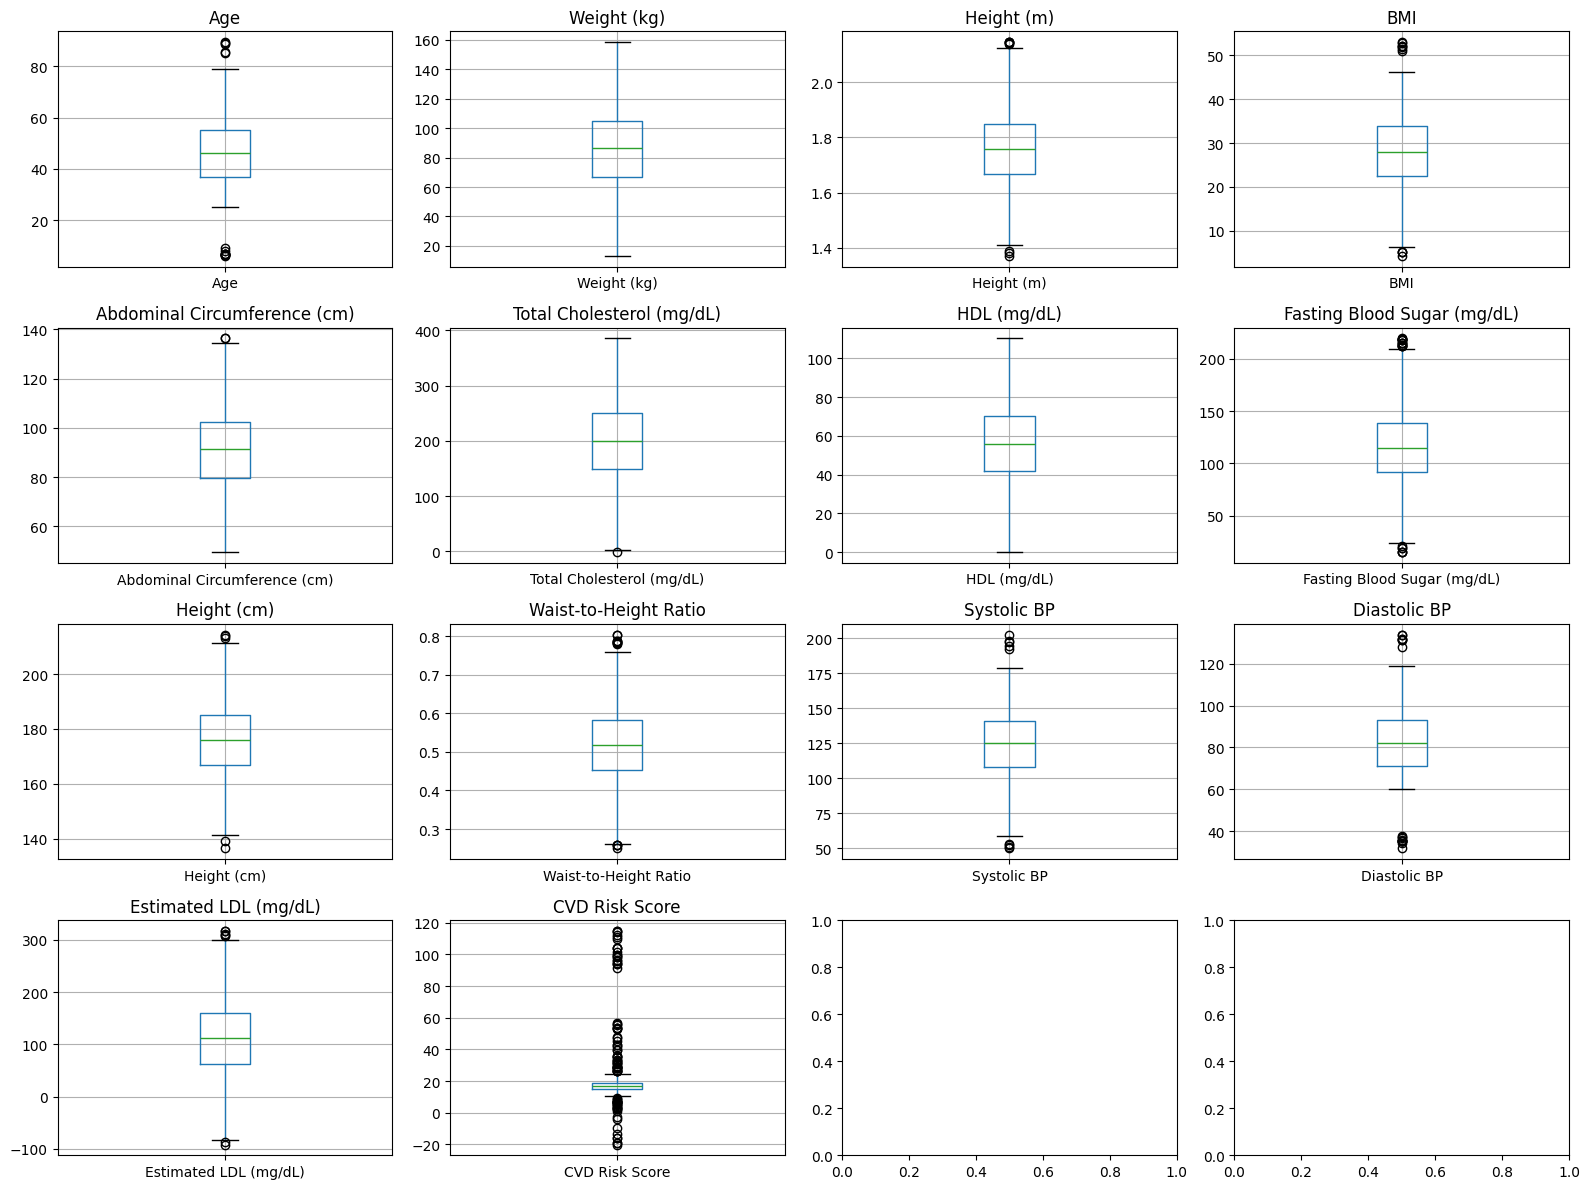

In [14]:
# Se incluyen unicamente variables numericas para los boxplots
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    if i < len(axes):
        data.boxplot(column=col, ax=axes[i])
        axes[i].set_title(col)

plt.tight_layout()
plt.show()

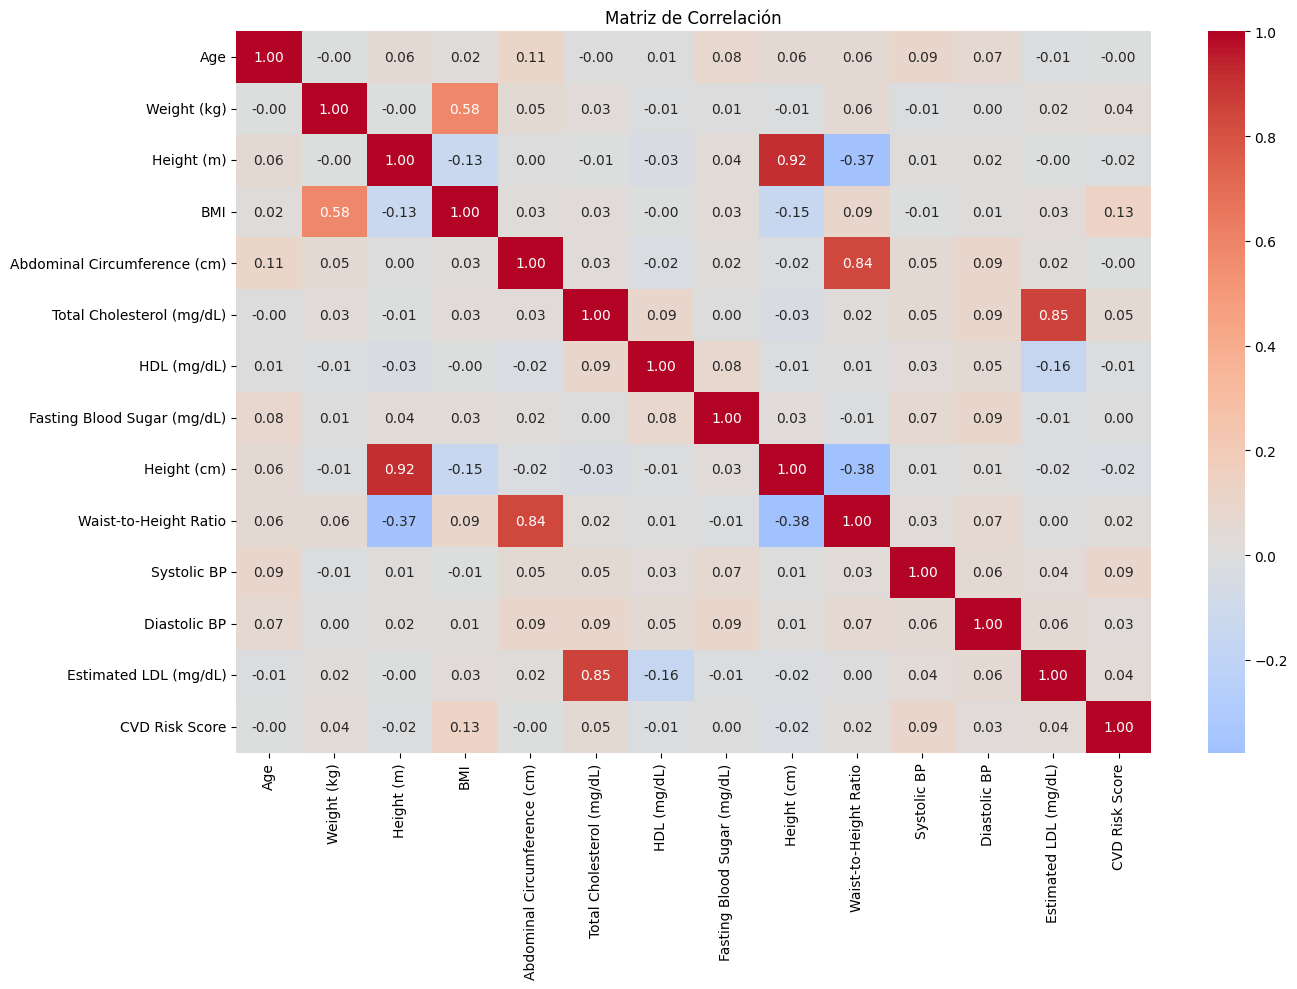

In [15]:
plt.figure(figsize=(14, 10))
sns.heatmap(data[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

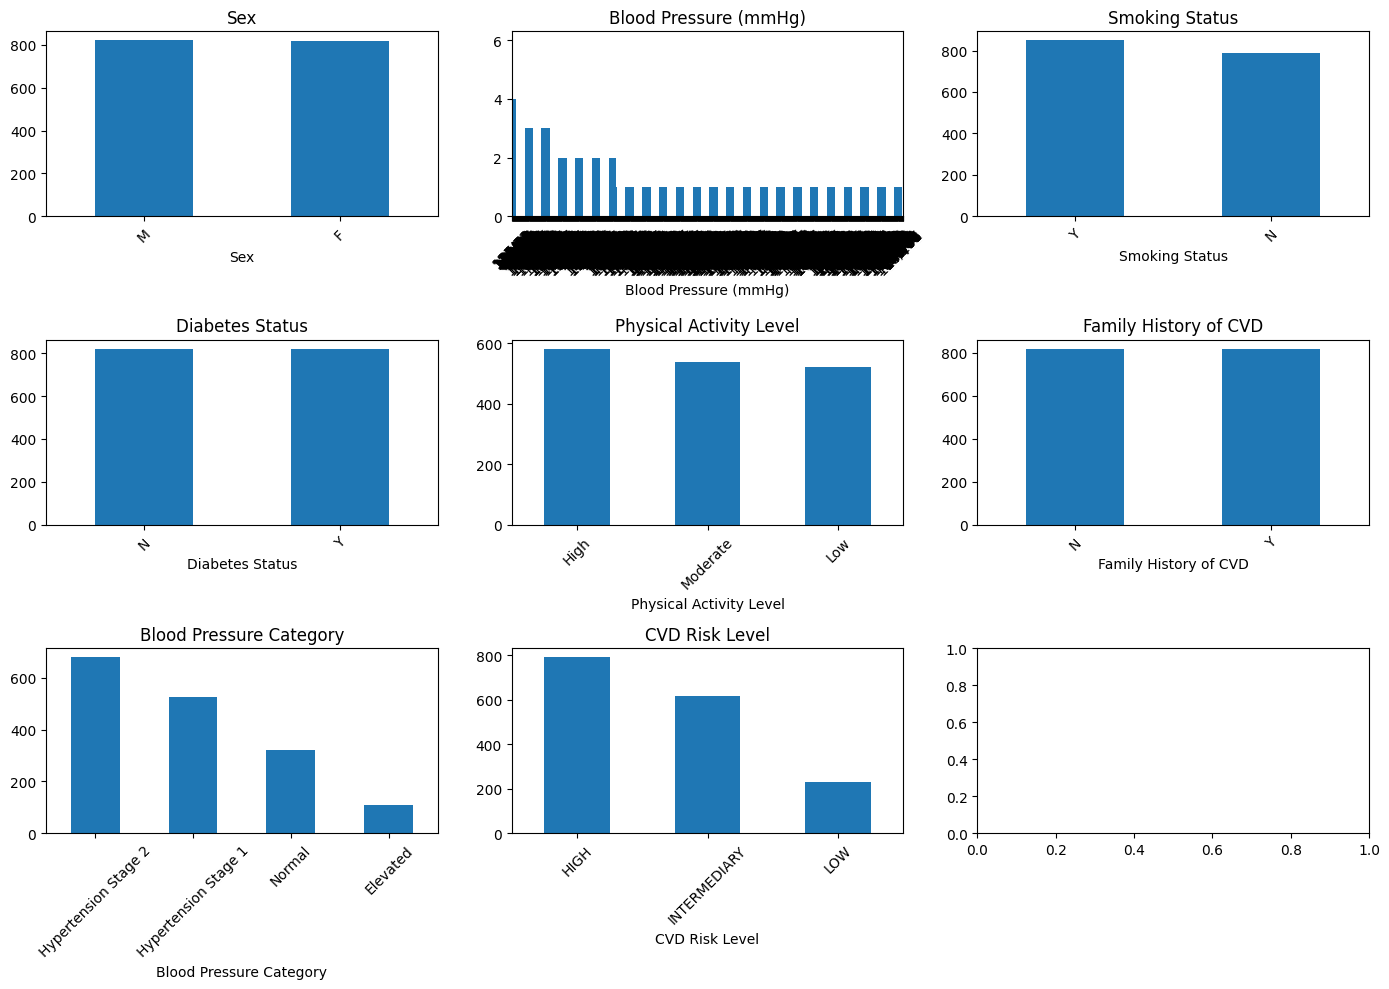

In [16]:
# Aqui se quitan los rubros 'Patient ID' y 'Date of Service'
categoricas = objetos[2:]

fig, axes = plt.subplots(3, 3, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(categoricas):
    if i < len(axes):
        data[col].value_counts().plot(kind='bar', ax=axes[i])
        axes[i].set_title(col)
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Diabetes Status            0.147817
Physical Activity Level    0.029594
Smoking Status             0.015322
Sex                        0.006157
Blood Pressure (mmHg)      0.003541
CVD Risk Level             0.001020
Family History of CVD     -0.041148
Blood Pressure Category   -0.080211
Name: CVD Risk Score, dtype: float64


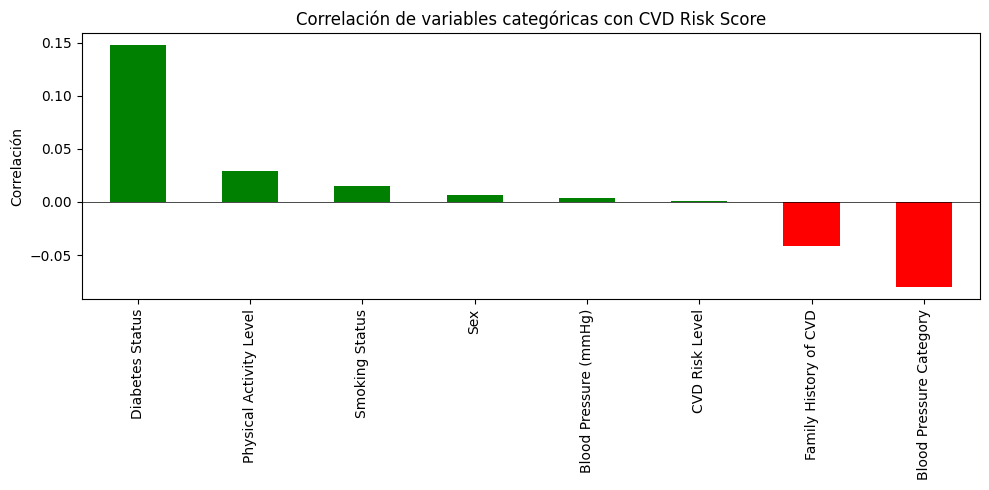

In [17]:
data_encoded = data.copy()

le = LabelEncoder()
for col in categoricas:
    data_encoded[col] = le.fit_transform(data_encoded[col])

# Correlacion con CVD Risk Score
correlaciones = data_encoded[categoricas + ['CVD Risk Score']].corr()['CVD Risk Score'].drop('CVD Risk Score').sort_values(ascending=False)

print(correlaciones)

plt.figure(figsize=(10, 5))
correlaciones.plot(kind='bar', color=['green' if x > 0 else 'red' for x in correlaciones])
plt.title('Correlación de variables categóricas con CVD Risk Score')
plt.ylabel('Correlación')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

#### Hallazgos de la exploración:

##### Valores imposibles detectados:
- Estimated LDL negativo (-92): fisiológicamente imposible
- CVD Risk Score negativo y >100: fuera de rango válido [0-100]
- Total Cholesterol ≈ 0: imposible
- HDL < 10: imposible
- BMI < 7: menor al mínimo registrado (~7.5)

##### Outliers extremos pero posibles:
- Age ~10: inusual para datos cardiovasculares
- BMI > 50: obesidad mórbida extrema
- CVD Risk Score > 60: pacientes de alto riesgo

##### Decisiones para preparación:
- Convertir valores imposibles a NaN
- Imputar con media del train después del split

##### Multicolinealidad
- Height (m) y Height (cm): 0.92 se debe eliminar una
- Total Cholesterol y Estimated LDL: 0.85 se deberia considerar eliminar una.
- Abdominal Circumference y Waist-to-Height ratio: 0.84 se deberia considerar eliminar una.
- Weight y BMI: 0.58 relacion a tener en cuenta.
- Blood Pressure = Systolic/Diastolic

##### Correlaciones con CVD Risk Score (Numericas)
- BMI: 0.13 la mas alta, pero debil.
- Systolic BP: 0.09
- El resto muy bajas ~0.

##### Correlaciones con CVD Risk Score (Categoricas)
- Diabetes Status: 0.15 es el mejor predictor
- Blood Pressure Category: -0.07
- Family History of CVD: -0.04
- CVD Risk Level: ~0 raro porque deberia derivarse del CVD Risk Score

### Preparación de datos

In [18]:
data = data.drop_duplicates()

Aqui se quitan las filas de datos duplicados.

In [19]:
data = data.copy()
data["Date of Service"] = pd.to_datetime(data["Date of Service"], format='mixed')
data
# TODO: Como se usa formato 'mixed', para datos como: 08-09-2022, se adivina cual es el mes y cual es el dia.

,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
0,isDx5313,2023-11-08,M,44.0,114.300,1.720,38.600,100.000,112/83,228.0,...,High,N,172.000,0.581,112.0,83.0,Hypertension Stage 1,121.0,19.880,HIGH
1,LHCK2961,2024-03-20,F,57.0,92.923,1.842,33.116,106.315,101/91,158.0,...,High,Y,184.172,0.577,101.0,91.0,Hypertension Stage 2,57.0,16.833,INTERMEDIARY
2,WjVn1699,2021-05-27,F,NaN,73.400,1.650,27.000,78.100,90/74,135.0,...,High,N,165.000,0.473,90.0,74.0,Normal,45.0,12.600,LOW
3,dCDO1109,2022-04-18,F,35.0,113.300,1.780,35.800,79.600,92/89,158.0,...,Moderate,Y,178.000,0.447,92.0,89.0,Hypertension Stage 1,94.0,14.920,HIGH
4,pnpE1080,2024-01-11,F,48.0,102.200,1.750,33.400,106.700,121/68,207.0,...,Low,Y,175.000,0.610,121.0,68.0,Elevated,128.0,18.870,HIGH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1632,ioby2183,2024-08-13,M,40.0,120.000,NaN,35.400,100.900,94/68,223.0,...,Moderate,Y,184.000,0.548,94.0,68.0,Normal,131.0,18.240,HIGH
1634,mrzf5858,2021-05-21,F,35.0,77.600,1.780,24.500,84.600,124/90,143.0,...,Low,N,178.000,0.475,124.0,90.0,Hypertension Stage 2,37.0,13.960,LOW
1635,nPnN5477,2022-12-04,F,35.0,92.005,1.726,NaN,98.692,95/111,156.0,...,High,N,172.602,0.572,95.0,111.0,Hypertension Stage 2,46.0,14.316,LOW
1637,QSFT6794,2025-09-06,M,49.0,NaN,1.630,23.100,93.800,144/91,191.0,...,Moderate,Y,163.000,0.575,144.0,NaN,Hypertension Stage 2,82.0,17.640,HIGH


Aqui se realiza la respectiva refactorizacion de las fechas.

In [20]:
# Convertir valores imposibles a NaN para luego imputar

# Estimated LDL: no puede ser negativo, rango 0 - 300
data.loc[data['Estimated LDL (mg/dL)'] < 0, 'Estimated LDL (mg/dL)'] = np.nan
data.loc[data['Estimated LDL (mg/dL)'] > 300, 'Estimated LDL (mg/dL)'] = np.nan

# CVD Risk Score: rango 0 - 100
data.loc[data['CVD Risk Score'] < 0, 'CVD Risk Score'] = np.nan
data.loc[data['CVD Risk Score'] > 100, 'CVD Risk Score'] = np.nan

# Total Cholesterol: no puede ser negativo
data.loc[data['Total Cholesterol (mg/dL)'] < 0, 'Total Cholesterol (mg/dL)'] = np.nan

# BMI: El valor minimo reportado en un ser viviente es de ~7.5
data.loc[data['BMI'] < 7, 'BMI'] = np.nan

Se clippearon valores imposibles de la base de datos.

In [21]:
# Conversion a m
height_m = data["Height (m)"]
height_cm_to_m = data["Height (cm)"] / 100

# Promedio donde ambos existen, sino el que existe
data.loc[:,"Height (m)"] = (height_m.fillna(height_cm_to_m) + height_cm_to_m.fillna(height_m)) / 2

data = data.drop(columns=["Height (cm)"])

Para el parametro height, se realizo: 
- Si existian tanto Height (m), como Height (cm), se calculo un promedio.
- Si solo existia uno de estos se dejo este.
- Si no existia se tomo como el promedio global de las estaturas.

In [22]:
BMI = (data["Weight (kg)"] / data["Height (m)"] ** 2)
data["BMI"] = data["BMI"].fillna(BMI)

Para los datos que no tenian BMI, se utilizo la formula del BMI para agregarla.
BMI = weight (kg) / height (m) ^2

In [23]:
bp_split = data['Blood Pressure (mmHg)'].str.split('/', expand=True).astype(float)
data['Systolic BP'] = data['Systolic BP'].fillna(bp_split[0])
data['Diastolic BP'] = data['Diastolic BP'].fillna(bp_split[1])

Aqui llenamos los datos restantes de `Systolic BP` y `Diastolic BP` con los respectivos datos que tienen en `Blood Pressure (mmHg)`.

In [24]:
WHtR = data['Abdominal Circumference (cm)'] / (data['Height (m)'] * 100)
data['Waist-to-Height Ratio'] = data['Waist-to-Height Ratio'].fillna(WHtR)

# Verificar rangos
print(data['Waist-to-Height Ratio'].describe())

count    1487.000000
mean        0.523331
std         0.085292
min         0.250000
25%         0.455000
50%         0.519000
75%         0.582000
max         0.825281
Name: Waist-to-Height Ratio, dtype: float64


Si bien es cierto que waist circumference es diferente de abdominal circumference, sigue siendo una aproximacion valida y suelen estar linealmente correlacionadas. Por lo que, para las filas de datos en las que faltan valores para el waist to height ratio, se decidio utilizar el rubro `Abdominal Circumference (cm)` y dividirlo entre el rubro de `Height (m)` * 100.

In [25]:
abdominal_circum = data['Height (m)'] * data['Waist-to-Height Ratio']/100
data['Abdominal Circumference (cm)'] = data['Abdominal Circumference (cm)'].fillna(abdominal_circum)

weight = data['BMI'] * (data['Height (m)'] ** 2)
data['Weight (kg)'] = data['Weight (kg)'].fillna(weight)

estimated_LDL = data['Total Cholesterol (mg/dL)'] - data['HDL (mg/dL)'] - 30
data['Estimated LDL (mg/dL)'] = data['Estimated LDL (mg/dL)'].fillna(estimated_LDL)

tc_calc = data['Estimated LDL (mg/dL)'] + data['HDL (mg/dL)'] + 30
data['Total Cholesterol (mg/dL)'] = data['Total Cholesterol (mg/dL)'].fillna(tc_calc)

hdl_calc = data['Total Cholesterol (mg/dL)'] - data['Estimated LDL (mg/dL)'] - 30
data['HDL (mg/dL)'] = data['HDL (mg/dL)'].fillna(hdl_calc)

Aqui, utilizamos los datos que ya tenemos para calcular algunos de los que faltan. Esto se pudo realizar para los rubros: 
- `Abdominal Circumference (cm)`
- `Weight (kg)`
- `Estimated LDL (mg/dL)`
- `Total Cholesterol (mg/dL)`
- `HDL (mg/dL)`

Sin embargo, siguen faltando algunos datos. 

In [26]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 1488 entries, 0 to 1638
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Patient ID                    1488 non-null   object        
 1   Date of Service               1488 non-null   datetime64[ns]
 2   Sex                           1488 non-null   object        
 3   Age                           1427 non-null   float64       
 4   Weight (kg)                   1487 non-null   float64       
 5   Height (m)                    1485 non-null   float64       
 6   BMI                           1487 non-null   float64       
 7   Abdominal Circumference (cm)  1487 non-null   float64       
 8   Blood Pressure (mmHg)         1488 non-null   object        
 9   Total Cholesterol (mg/dL)     1481 non-null   float64       
 10  HDL (mg/dL)                   1482 non-null   float64       
 11  Fasting Blood Sugar (mg/dL)   1439 

#### Ingeniería de características

Continuando la fase de preparacion de datos, se va a realizar una agregacion de features que podrian ser importantes para revisar cuales de estas podrian enriquecer el modelo.

Las variables que se tomaran en cuenta para esta parte son: 
- Transformaciones de fila: Grupo etario, Categoria BMI, Categoria glucosa
- Formulas con datos de la misma fila: Ratio colesterol, Pulse Pressure, MAP
- Derivadas: Mes, Dia de semana, Estacion
- Interacciones: Fumador + Diabetes, BMI x Actividad
- Formulas Establecidas: Framingham, ASCVD

In [27]:
def framingham_score(row):
    score = 0
    
    # Edad
    if row['Age'] >= 55: score += 3
    elif row['Age'] >= 45: score += 2
    elif row['Age'] >= 35: score += 1
    
    # Sexo (hombres tienen mayor riesgo)
    if row['Sex'] == 'M': score += 1
    
    # Colesterol Total
    if row['Total Cholesterol (mg/dL)'] >= 280: score += 3
    elif row['Total Cholesterol (mg/dL)'] >= 240: score += 2
    elif row['Total Cholesterol (mg/dL)'] >= 200: score += 1
    
    # HDL (protector, menor = peor)
    if row['HDL (mg/dL)'] < 35: score += 2
    elif row['HDL (mg/dL)'] < 45: score += 1
    elif row['HDL (mg/dL)'] >= 60: score -= 1
    
    # Presión sistólica
    if row['Systolic BP'] >= 160: score += 3
    elif row['Systolic BP'] >= 140: score += 2
    elif row['Systolic BP'] >= 130: score += 1
    
    # Fumador
    if row['Smoking Status'] == 'Y': score += 2
    
    # Diabetes
    if row['Diabetes Status'] == 'Y': score += 2
    
    return score


def ascvd_score(row):
    score = 0
    
    # Edad (mas peso)
    score += row['Age'] * 0.5
    
    # Sexo 
    if row['Sex'] == 'M': score += 5
    
    # Colesterol
    score += row['Total Cholesterol (mg/dL)'] * 0.02
    score -= row['HDL (mg/dL)'] * 0.05
    
    # Presion
    score += row['Systolic BP'] * 0.03
    
    # Factores binarios
    if row['Smoking Status'] == 'Y': score += 7
    if row['Diabetes Status'] == 'Y': score += 5
    
    return score


def grupo_etario(age):
    if age < 30: return 'Joven'
    elif age < 45: return 'Adulto'
    elif age < 60: return 'Adulto Mayor'
    else: return 'Senior'
    
    
def categoria_bmi(bmi):
    if bmi < 18.5: return 'Bajo peso'
    elif bmi < 25: return 'Normal'
    elif bmi < 30: return 'Sobrepeso'
    else: return 'Obesidad'
    
    
def categoria_glucosa(fbs):
    if fbs < 100: return 'Normal'
    elif fbs < 126: return 'Prediabetes'
    else: return 'Diabetes'

In [28]:
# Derivadas simples
data['Pulse Pressure'] = data['Systolic BP'] - data['Diastolic BP']
data['MAP'] = data['Diastolic BP'] + (data['Pulse Pressure'] / 3)
data['Cholesterol Ratio'] = data['Total Cholesterol (mg/dL)'] / data['HDL (mg/dL)'] # Queda con unos cuantos valores NaN

# Temporales
data['Month'] = data['Date of Service'].dt.month
data['DayOfWeek'] = data['Date of Service'].dt.dayofweek
data['Year'] = data['Date of Service'].dt.year

# Interacciones
data['Smoker_Diabetic'] = (data['Smoking Status'] == 'Y') & (data['Diabetes Status'] == 'Y')

# BMI x Actividad
activity_risk = {'Low': 3, 'Moderate': 2, 'High': 1}
data['Activity Risk'] = data['Physical Activity Level'].map(activity_risk)

Estas variables podemos agregarlas a la base de datos antes de realizar el split entre training y testing. 

Sin embargo, algunas de las variables de interes que se quieren evaluar se realizaran despues del split.

#### Split
Ahora, realizamos el split de los datos con una semilla de 42 (random_state) y un porcentaje de 25% para el tamaño del conjunto de prueba (test_size=0.25).

In [29]:
exclude_cols = ['CVD Risk Score', 'CVD Risk Level', 'Patient ID', 
                'Date of Service', 'Blood Pressure (mmHg)']

X = data.drop(columns=exclude_cols) 
Y = data['CVD Risk Score']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 1116, Test: 372


#### Imputacion y Agregacion de 6 Features extras

In [ ]:
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

imputer_cat = SimpleImputer(strategy='most_frequent')
X_train[categorical_cols] = imputer_cat.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = imputer_cat.transform(X_test[categorical_cols])

imputer_num = SimpleImputer(strategy='mean')
X_train[numerical_cols] = imputer_num.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = imputer_num.transform(X_test[numerical_cols])

# Creacion de features X_train
X_train['Age Group'] = X_train['Age'].apply(grupo_etario)
X_train['BMI Category'] = X_train['BMI'].apply(categoria_bmi)
X_train['Glucose Category'] = X_train['Fasting Blood Sugar (mg/dL)'].apply(categoria_glucosa)
X_train['BMI x Sedentarism'] = X_train['BMI'] * X_train['Activity Risk']
X_train['ASCVD Score'] = X_train.apply(ascvd_score, axis=1)
X_train['Framingham Score'] = X_train.apply(framingham_score, axis=1)

# Creacion de features X_test
X_test['Age Group'] = X_test['Age'].apply(grupo_etario)
X_test['BMI Category'] = X_test['BMI'].apply(categoria_bmi)
X_test['Glucose Category'] = X_test['Fasting Blood Sugar (mg/dL)'].apply(categoria_glucosa)
X_test['BMI x Sedentarism'] = X_test['BMI'] * X_test['Activity Risk']
X_test['ASCVD Score'] = X_test.apply(ascvd_score, axis=1)
X_test['Framingham Score'] = X_test.apply(framingham_score, axis=1)

### Construcción de un modelo de regresión lineal

In [ ]:
datos_prueba = pd.read_csv(
    './Datos/Datos Test Lab 1.csv',
    sep=';'
)